## Loading Packages

In [43]:
import pandas as pd
import nltk as nltk

from google.cloud import storage
import io

In [44]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [45]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [46]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading Data

In [42]:
path = 'gs://msca-bdp-tweets/final_project'
data = spark.read.json(path)

In [6]:
data.count()

25191000

In [7]:
data.show(5)

+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+--------------------+-------------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+---------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sen

In [8]:
data.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: bo

In [ ]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [12]:
pd_view = data.limit(1000).toPandas()

In [13]:
pd_view.head(n=3)

contributors coordinates                      created_at display_text_range  \
0         None        None  Sat Oct 30 02:52:21 +0000 2021               None   
1         None        None  Sat Oct 30 02:52:21 +0000 2021               None   
2         None        None  Sat Oct 30 02:52:21 +0000 2021           [17, 77]   

                                                                                                                                         entities  \
0                                                     ([], None, [], [], [(754006735468261376, 754006735468261376, [3, 11], MONTERO 🦋, LilNasX)])   
1  ([], None, [], [(twitter.com/i/web/status/1…, https://twitter.com/i/web/status/1454279982096789505, [117, 140], https://t.co/AQa9LVqVm9)], [])   
2                                              ([], None, [], [], [(266929217, 266929217, [0, 16], Roaring Mice but Spoooooky, GarrAarghHrumph)])   

  extended_entities  \
0              None   
1              None   
2              None   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             extended_tweet  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      None   
1  ([0, 238], ([Row(indices=[168, 175], text='church'), Row(indices=[176, 192], text='taxexemptstatus'), Row(indices=[193, 213], text='politicalactivities')], None, [], [Row(display_url='businessinsider.com/doug-mastriano…', expanded_url='https://www.businessinsider.com/doug-mastriano-suggests-covid-19-vaccines-are-not-true-vaccines-2021-10?utm_source=taboola', indices=[215, 238], url='https://t.co/ye7jjVAFaB')], []), None, “At a political fundraiser hosted by the tax-exempt, evangelical Time Ministries Church in central Pennsylvania…” Nothing wrong w THAT statement at all. Of course not. #church #taxexemptstatus #politicalactivities  https://t.co/ye7jjVAFaB)   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      None   

   favorite_count  favorited filter_level  ... reply_count  retweet_count  \
0               0      False          low  ...           0              0   
1               0      False          low  ...           0              0   
2               0      False          low  ...           0             

## Discard Irrelevant Rows

In [47]:
df_text_covid = data.filter(lower(data.text).contains("covid"))

In [8]:
df_text_covid.show(5)

+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+--------------------+-------------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+---------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sen

In [19]:
df_text_covid.count()

14973841

Now we have only COVID related tweets in new dataframe.

In [21]:
pd_view = df_text_covid.limit(1000).toPandas()

In [22]:
pd_view.head(n=3)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,...,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,withheld_in_countries
0,None,None,Sat Oct 30 02:52:21 +0000 2021,"[17, 77]","([], None, [], [], [(266929217, 266929217, [0, 16], Roaring Mice but Spoooooky, GarrAarghHrumph)])",None,None,0,False,low,...,0,0,False,None,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@GarrAarghHrumph I got my Covid booster today too, and then ate pesto fries 😂",1635562341946,False,"(False, Mon May 21 04:31:56 +0000 2012, True, False, Mostly skating banter and sarcasm....plentiful sarcasm., 1103, None, 70, None, 172, False, 586248544, 586248544, False, None, 4, Michigan, USA, Emily Joy, None, C0DEED, http://abs.twimg.com/images/themes/theme1/bg.png, https://abs.twimg.com/images/themes/theme1/bg.png, False, https://pbs.twimg.com/profile_banners/586248544/1484372798, http://pbs.twimg.com/profile_images/820145069059698696/bHEaLS3w_normal.jpg, https://pbs.twimg.com/profile_images/820145069059698696/bHEaLS3w_normal.jpg, 1DA1F2, C0DEED, DDEEF6, 333333, True, False, JoyofEmily, 2389, None, none, None, None, False, [])",None
1,None,None,Sat Oct 30 02:52:22 +0000 2021,None,"([], None, [], [], [(1318094385431662593, 1318094385431662593, [3, 19], Denise 🦕, Denise_Old_Lady)])",None,None,0,False,low,...,0,0,False,"(None, None, Sat Oct 30 02:49:15 +0000 2021, None, ([], None, [], [], []), None, None, 0, False, low, None, 1454279200320405505, 1454279200320405505, None, None, None, None, None, True, en, None, None, 0, (None, None, Fri Oct 29 21:01:22 +0000 2021, [17, 140], ([], None, [], [Row(display_url='twitter.com/i/web/status/1…', expanded_url='https://twitter.com/i/web/status/1454191652545843201', indices=[117, 140], url='https://t.co/d0WyAA6jhx')], [Row(id=762389795037294592, id_str='762389795037294592', indices=[0, 16], name='Melissa Tate', screen_name='TheRightMelissa')]), None, ([17, 159], Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[Row(id=762389795037294592, id_str='762389795037294592', indices=[0, 16], name='Melissa Tate', screen_name='TheRightMelissa')]), None, @TheRightMelissa He doesn't have the right to infect others with covid. If he stays home 24/7 I am ok with this decision, otherwise he needs to get vaccinated.), 17, False, low, None, 1454191652545843201, 1454191652545843201, TheRightMelissa, 1454173330995560452, 1454173330995560452, 762389795037294592, 762389795037294592, False, en, None, None, 5, None, None, 97, 0, False, None, <a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>, @TheRightMelissa He doesn't have the right to infect others with covid. If he stays home 24/7 I am ok with this dec… https://t.co/d0WyAA6jhx, True, (False, Mon Dec 14 02:24:30 +0000 2009, False, False, Average human and coder, obj-c enthusiast. CEO of myself, inc. - checkout http://ipban.com | http://digitalruby.com | https://www.linkedin.com/in/jjxtra/, 972, None, 291, None, 27, False, 96674788, 96674788, False, None, 8, Salt Lake City, Utah, USA, Jeff Johnson, None, FFFFFF, http://abs.twimg.com/images/themes/theme9/bg.gif, https://abs.twimg.com/images/themes/theme9/bg.gif, True, https://pbs.twimg.com/profile_banners/96674788/1599672180, http://pbs.twimg.com/profile_images/1261494410987974656/JnirceDl_normal.jpg, https://pbs.twimg.com/profile_images/1261494410987974656/JnirceDl_normal.jpg, 2FC2EF, 000000, 252429, 666666, True, False, jjxtra, 1182, None, none, http://www.digitalruby.com, None, False, []), None, None), 1454191652545843201, 1454191652545843201, (twitter.com/jjxtra/status/…, https://twitter.com/jjxtra/status/1454191652545843201, https://t.co/1nPY5cuBFx), 0, 1, False, None, <a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>, Duh, don't you know that vaccinated people can still get &amp; spread covid?, 

## EDA

In [ ]:
df_text_covid.describe()

summary,contributors,created_at,favorite_count,filter_level,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,lang,quote_count,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,source,text,timestamp_ms
count,0,14973841,14973841,14973841,14973841,14973841,1907987,1843873,1843873,1907987,1907987,14973841,14973841,1251878,1251878,14973841,14973841,14973841,14973841,14973841
mean,null,null,0.0,null,1.453828677557415...,1.453828677557415...,Infinity,1.453069542240005...,1.453069542240005...,4.393414073436544...,4.393414073436544...,null,0.0,1.450464480089800...,1.450464480089800...,0.0,0.0,null,null,1.635454742217016...
stddev,null,null,0.0,null,2.963188286377231E15,2.963188286377231E15,NaN,1.468956448959299...,1.468956448959299...,5.829131551857952E17,5.829131551857952E17,null,0.0,2.755848711217400...,2.755848711217400...,0.0,0.0,null,null,7.064791408485224E8
min,null,Fri Nov 05 00:00:...,0,low,1448850337247367173,1448850337247367173,000000001404072,15754281,1001725136045793280,12,1000002715999784961,en,0,1403739068,1000324596757942272,0,0,"<a href=""HTTP://b...",! An extremely s...,1634267813394
max,null,Wed Oct 27 23:59:...,0,low,1459021442469666820,1459021442469666820,zzzzzz_cz17,1459021288719200304,998963717004935169,1458982120475398146,999991396445585410,en,0,1459020209969238020,999652465548054533,0,0,"<a href=""https://...",🫖After a long CO...,1636692793849


In [ ]:
df_text_covid.select('user.*').describe()

summary,created_at,description,favourites_count,follow_request_sent,followers_count,following,friends_count,id,id_str,lang,listed_count,location,name,notifications,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_banner_url,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,screen_name,statuses_count,time_zone,translator_type,url,utc_offset
count,14973841,12157041,14973841,0,14973841,0,14973841,14973841,14973841,0,14973841,9339784,14973841,0,14973841,14973841,14973841,10835730,14973841,14973841,14973841,14973841,14973841,14973841,14973841,14973841,0,14973841,3418585,0
mean,null,NaN,50991.78209311826,null,17475.372439509676,null,1898.6950489857613,5.452431257649341...,5.452431257649341...,null,98.5231971542906,Infinity,NaN,null,Infinity,null,null,null,null,null,Infinity,Infinity,Infinity,Infinity,NaN,61048.95219256035,null,null,null,null
stddev,null,NaN,94136.20553954745,null,430200.61144864897,null,6190.863227390212,6.030971783515087...,6.030971783515087...,null,1800.0366636905208,NaN,NaN,null,NaN,null,null,null,null,null,NaN,NaN,NaN,NaN,NaN,139087.01434812212,null,null,null,null
min,Fri Apr 01 00:00:...,!,0,null,0,null,0,21,1000000322897498112,null,0,"Hanoi, Vietnam",,null,000000,,,https://pbs.twimg...,http://abs.twimg....,https://abs.twimg...,000000,000000,000000,000000,0000000000Nikki,1,null,badged,Celebritycooks.net,null
max,Wed Sep 30 23:59:...,􏰥 􏰦􏰧􏰨􏰩􏰪􏰫􏰬...,3107041,null,72387322,null,4183880,1459017425274368000,999999913500004352,null,211675,🫕 16 he him gw 98,󾬍(🌸•ั็в•็ฅ󾬍🍑 ...,null,FFFFFF,http://abs.twimg....,https://abs.twimg...,https://pbs.twimg...,http://pbs.twimg....,https://pbs.twimg...,FFFFFF,FFFFFF,FFFFFF,FFFFFF,zzzzzzzzzzzzjj,6007489,null,regular,www.segamihcfund.org,null


In [ ]:
df_text_covid.select('user.*').printSchema()

root
 |-- contributors_enabled: boolean (nullable = true)
 |-- created_at: string (nullable = true)
 |-- default_profile: boolean (nullable = true)
 |-- default_profile_image: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- favourites_count: long (nullable = true)
 |-- follow_request_sent: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- following: string (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- geo_enabled: boolean (nullable = true)
 |-- id: long (nullable = true)
 |-- id_str: string (nullable = true)
 |-- is_translator: boolean (nullable = true)
 |-- lang: string (nullable = true)
 |-- listed_count: long (nullable = true)
 |-- location: string (nullable = true)
 |-- name: string (nullable = true)
 |-- notifications: string (nullable = true)
 |-- profile_background_color: string (nullable = true)
 |-- profile_background_image_url: string (nullable = true)
 |-- profile_background_image_url_https: string (nulla

In [10]:
df_text_covid.select('place.*').printSchema()

root
 |-- bounding_box: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- country: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- full_name: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- url: string (nullable = true)



Given "contributors" is an empty column, and "quote_count", "reply_count", "retweet_count" are all 0's, we drop the columns from our dataframe. 

We also count the null values in each column to filter out variables that are poorly populated. 

In [ ]:
df_filter_var = df_text_covid.agg(*[count(when(isnull(c), c)).alias(c) for c in df_text_covid.columns])


In [ ]:
df_filter_var.show()

+------------+-----------+----------+------------------+--------+-----------------+--------------+--------------+---------+------------+--------+---+------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+--------+------------------+-----------+-------------+----------------+--------------------+-----------------------+-----------+-------------+---------+----------------+------+----+------------+---------+----+---------------------+
|contributors|coordinates|created_at|display_text_range|entities|extended_entities|extended_tweet|favorite_count|favorited|filter_level|     geo| id|id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|   place|possibly_sensitive|quote_count|quoted_status|quoted_status_id|quoted_status_id_str|quoted_status_permalink|reply_count|retweet_count|retweeted|retweeted_status|source|text|t

In [ ]:
pd_view = df_filter_var.limit(100000).toPandas()

In [ ]:
pd_view.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,...,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,withheld_in_countries
0,14973841,14972160,0,12761230,0,14298467,12865521,0,0,0,...,0,0,0,4331054,0,0,0,0,0,14972161


We then drop the columns that are poorly populated, i.e. are mainly null values, and the variables that consists of only 0. 

In [12]:
df_cleaned = df_text_covid.drop("contributors", "coordinates", "withheld_in_countries", "quote_count", "reply_count", "retweet_count")


In [12]:
df_cleaned.show(5)

+--------------------+------------------+--------------------+-----------------+--------------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+--------------------+-------------------+--------------------+-----------------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+
|          created_at|display_text_range|            entities|extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|       quoted_status|   quoted_status_id|quoted_status_id_str|quoted_status_permalink|retweeted|    ret

In [13]:
df_cleaned.count()

14973841

## Identifying Most Influential Twitterers

### By Message Volume

#### By Tweeterer

We first construct a dataframe out of user id, their message and message volume measured by text word count. Construct a filtered dataframe that would exclude both retweets and replies, keeping only original content.

In [48]:
df_message_vol = df_cleaned.filter('in_reply_to_status_id IS NULL').filter('retweeted_status IS NULL').filter('quoted_status_id IS NULL').\
select('user.name', 'user.screen_name', 'user.description', 'user.followers_count')


In [65]:
df_message_vol.count()

2179970

In [14]:
df_message_vol.show(5)

+---------------------+--------------+---------------------+---------------+
|                 name|   screen_name|          description|followers_count|
+---------------------+--------------+---------------------+---------------+
|    Pal-Mac Athletics|  palmacsports| Director of PE, A...|            932|
|                HOOTS|  GarethHooton| Fun Football & T-...|            240|
|  Sherry Lynne Howard|     63Sherry_|                 null|             47|
|. ⁺ ✦ Midnight ─・...|fviryxmidnight|・ʚ Midnight┆─ ↷ s...|            301|
| WORLD LEADER 1 AR...|ARTHURGCARTER1| Mission -INDIVIDU...|             27|
+---------------------+--------------+---------------------+---------------+
only showing top 5 rows



In [49]:
df_message_vol_influencer = df_message_vol.groupBy('name', 'screen_name', 'description','followers_count').agg(count('*').alias('message_volume')).orderBy('message_volume', ascending = False)




#### By Organization

In [50]:
org_gov = ['gov', 'congress', 'representative', 'presiden']
org_health = ['health', 'hospital']
org_news = ['news', 'press', 'post', 'journal']
org_social_media = ['youtuber', 'streamer', 'tik tok', 'influencer']
org_celebrity = ['singer', 'musician', 'actor', 'actress', 'movie', 'producer', 'rapper']

In [51]:
org_dict = {'government': org_gov, 
            'health': org_health,
            'news' : org_news,
            'social_media' : org_social_media,
            'celebrity' : org_celebrity
           }

In [52]:
df_message_vol = df_message_vol.\
withColumn("organization",lit("other"))

In [53]:
df_message_vol.show(5)

+---------------------+--------------+---------------------+---------------+------------+
|                 name|   screen_name|          description|followers_count|organization|
+---------------------+--------------+---------------------+---------------+------------+
|    Pal-Mac Athletics|  palmacsports| Director of PE, A...|            932|       other|
|                HOOTS|  GarethHooton| Fun Football & T-...|            240|       other|
|  Sherry Lynne Howard|     63Sherry_|                 null|             47|       other|
|. ⁺ ✦ Midnight ─・...|fviryxmidnight|・ʚ Midnight┆─ ↷ s...|            301|       other|
| WORLD LEADER 1 AR...|ARTHURGCARTER1| Mission -INDIVIDU...|             27|       other|
+---------------------+--------------+---------------------+---------------+------------+
only showing top 5 rows



In [54]:
for key, value in org_dict.items():
    for k in value:
        df_message_vol = df_message_vol.\
        withColumn("organization", when(lower(df_message_vol.description).contains(k), key).\
                   otherwise(df_message_vol.organization))


In [55]:
df_message_vol_org = df_message_vol.groupBy('organization').agg(count('*').alias('message_volume'), sum('followers_count').alias('followers_count')).orderBy('message_volume', ascending = False)



In [ ]:
df_message_vol_org.show(30)

+------------+--------------+---------------+
|organization|message_volume|followers_count|
+------------+--------------+---------------+
|       other|       1518737|    24781381697|
|        news|        476511|   163229002277|
|      health|         97319|     2882874584|
|  government|         42398|     1712562934|
|   celebrity|         37152|      421680367|
|social_media|          7853|      194839283|
+------------+--------------+---------------+



In [56]:
df_message_vol_ind = df_message_vol.groupBy('name', 'screen_name', 'organization').agg(count('*').alias('message_volume'), max('followers_count').alias('followers_count')).orderBy('message_volume', ascending = False)


In [31]:
df_message_vol_ind.show(30)

+--------------------+---------------+------------+--------------+---------------+
|                name|    screen_name|organization|message_volume|followers_count|
+--------------------+---------------+------------+--------------+---------------+
|       Nathan Joyner| njoyflyfishing|       other|         15349|             21|
|            Galla Go|       galla_go|       other|          4673|            267|
|         iWeller.com| iWeller_health|       other|          4591|            122|
|            News Bht|       newsbht1|        news|          4504|            860|
|     hiremaid.com.sg|     HIREMAIDEA|       other|          4331|            110|
| Coronavirus Updates|      COVIDLive|        news|          3655|           1201|
|         TittlePress|    TittlePress|       other|          2642|             70|
|        Andy Vermaut|    AndyVermaut|        news|          2563|          29803|
|             news in|      newsgang2|       other|          2517|            193|
|   

In [85]:
df_message_vol_ind = df_message_vol_ind.withColumn('exposure', df_message_vol_ind.message_volume * df_message_vol_ind.followers_count)

In [86]:
df_message_vol_ind_expo = df_message_vol_ind.orderBy('exposure', ascending = False)

In [106]:
df_message_vol_org_expo = df_message_vol_org.withColumn('exposure', df_message_vol_org.message_volume * df_message_vol_org.followers_count)



In [107]:
df_message_vol_ind_expo = df_message_vol_org_expo.orderBy('exposure', ascending = False)

In [98]:
#Saving results of massage volume
bucket_write = 'msca-bdp-students-bucket/shared_data/haoruw'

In [ ]:
df_message_vol_org.write.format("com.databricks.spark.csv").\
option("header", "true").\
mode('overwrite').\
save('gs://' + bucket_write + '/df_message_vol_org_csv')

In [ ]:
df_mv1 = spark.read.csv('gs://' + bucket_write + '/df_message_vol_org_csv', header='true', inferSchema='true')

In [ ]:
df_mv1.show(30)

+------------+--------------+
|organization|message_volume|
+------------+--------------+
|social_media|          7853|
|  government|         42398|
|   celebrity|         37152|
|       other|       1518737|
|      health|         97319|
|        news|        476511|
+------------+--------------+



### Data Visualization

In [57]:
df_message_vol_ind_top50 = df_message_vol_ind.limit(50)

In [ ]:
p_df_message_vol_ind_expo = df_message_vol_ind_expo.limit(30).toPandas()

In [58]:
df_message_vol_ind_top50.show()

+--------------------+---------------+------------+--------------+---------------+
|                name|    screen_name|organization|message_volume|followers_count|
+--------------------+---------------+------------+--------------+---------------+
|       Nathan Joyner| njoyflyfishing|       other|         15349|             21|
|            Galla Go|       galla_go|       other|          4673|            267|
|         iWeller.com| iWeller_health|       other|          4591|            122|
|            News Bht|       newsbht1|        news|          4504|            860|
|     hiremaid.com.sg|     HIREMAIDEA|       other|          4331|            110|
| Coronavirus Updates|      COVIDLive|        news|          3655|           1201|
|         TittlePress|    TittlePress|       other|          2642|             70|
|        Andy Vermaut|    AndyVermaut|        news|          2563|          29803|
|             news in|      newsgang2|       other|          2517|            193|
|   

In [ ]:
p_message_vol_influencer = df_message_vol_ind_top50.limit(30).toPandas()

In [62]:
bucket_write = 'msca-bdp-students-bucket/shared_data/haoruw'

In [64]:
p_message_vol_influencer.to_csv('gs://' + bucket_write + '/df_message_vol_org_csv', header='true')




In [ ]:
p_message_vol_influencer_expo.to_csv('gs://' + bucket_write + '/p_message_vol_influencer_expo', header='true')

In [65]:
p_message_vol_influencer.head(n=10)

,name,screen_name,organization,message_volume,followers_count
0,Nathan Joyner,njoyflyfishing,other,15349,21
1,Galla Go,galla_go,other,4673,267
2,iWeller.com,iWeller_health,other,4591,122
3,News Bht,newsbht1,news,4504,860
4,hiremaid.com.sg,HIREMAIDEA,other,4331,110
5,Coronavirus Updates,COVIDLive,news,3655,1201
6,TittlePress,TittlePress,other,2642,70
7,Andy Vermaut,AndyVermaut,news,2563,29803
8,news in,newsgang2,other,2517,193
9,Humming Zone,Humming_Zone,news,2330,794


In [77]:
p_message_vol_influencer['exposure'] = p_message_vol_influencer['message_volume'] * p_message_vol_influencer['followers_count']

In [79]:
p_message_vol_influencer.sort_values('exposure', ascending=False)

,name,screen_name,organization,message_volume,followers_count,exposure
20,Tomthunkit™,TomthunkitsMind,other,1627,87360,142134720
7,Andy Vermaut,AndyVermaut,news,2563,29803,76385089
12,save DEMOCRACY,VippusaO,other,2153,4833,10405449
5,Coronavirus Updates,COVIDLive,news,3655,1201,4389655
3,News Bht,newsbht1,news,4504,860,3873440
21,Top Most Popular News,TPM_NEWS,news,1539,1799,2768661
16,Qamar Afzaal Bhatti,_qbhatti,other,2002,1155,2312310
26,COVID Scale,COVID_Scale,other,1318,1481,1951958
9,Humming Zone,Humming_Zone,news,2330,794,1850020
1,Galla Go,galla_go,other,4673,267,1247691


In [98]:
expo_merge1 = p_message_vol_influencer.drop(columns=['message_volume', 'followers_count'])

In [99]:
expo_merge2 = p_retweet_ind_top30_expo.drop(columns=['followers_count'])

In [102]:
p_expo = expo_merge2.append(expo_merge1)

In [103]:
p_expo.count()

name            60
screen_name     60
organization    60
exposure        60
dtype: int64

In [105]:
p_expo.sort_values('exposure', ascending=False).head(n=30)

,name,screen_name,organization,exposure
0,Big L,itslinzzzz,other,2018771467
1,rebecca,abcdrih,other,1238205652
2,Big Bird,BigBird,other,930192264
3,Supreme Pas-Bey,8EightPillars,other,466751414
4,Amani🛥 *,Sasyity,other,280612905
5,PeterSweden,PeterSweden7,news,261079889
6,"Robert W Malone, MD",RWMaloneMD,other,241470577
7,Jack Johnson IV,jackjohnsoniv7,other,227687366
8,Chris Simms,CSimmsQB,other,220524757
9,The BMJ,bmj_latest,news,186685237


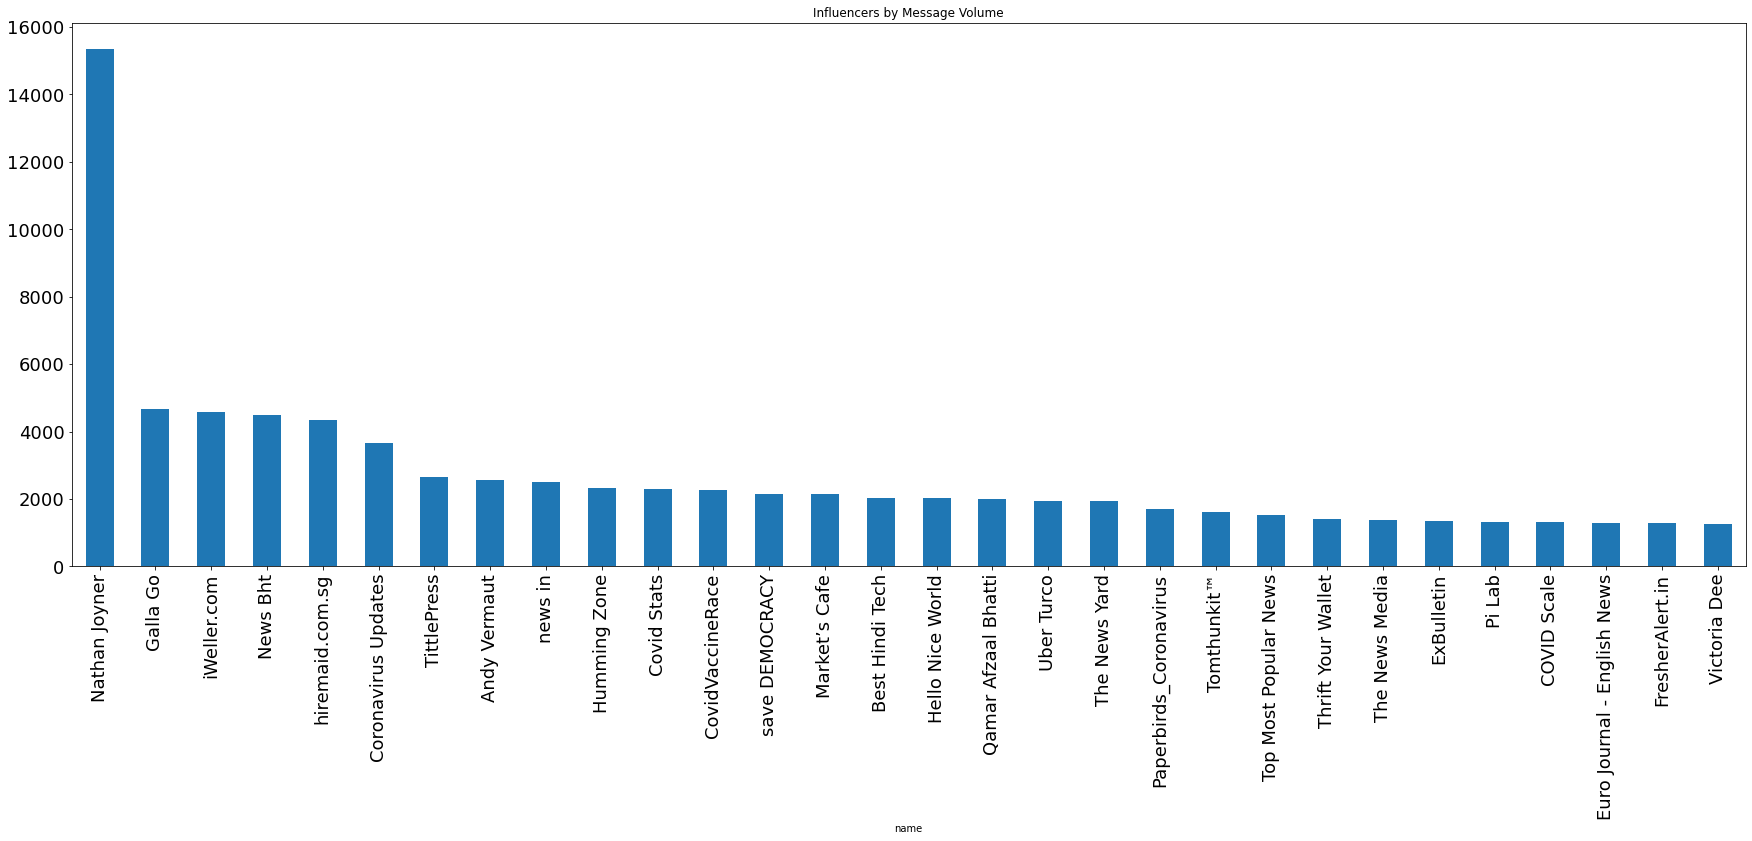

In [67]:
my_plot = p_message_vol_influencer.plot(kind='bar',x='name', y='message_volume', legend=None, title="Influencers by Message Volume", figsize=(30,10), fontsize = 18)


In [178]:
p_message_vol_org = df_message_vol_org.limit(50).toPandas()

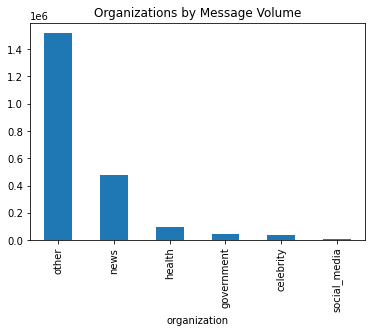

In [187]:
my_plot2 = p_message_vol_org.plot(kind='bar',x='organization', y='message_volume', legend=None, title="Organizations by Message Volume")



In [186]:
p_message_vol_org_exclude = p_message_vol_org.drop(index=0, axis=1)

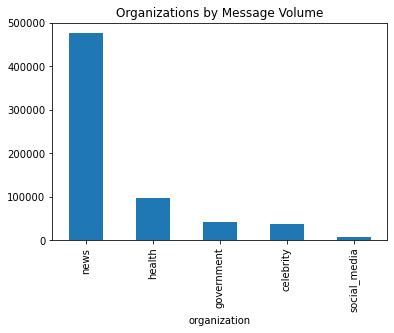

In [188]:
my_plot3 = p_message_vol_org_exclude.plot(kind='bar',x='organization', y='message_volume', legend=None, title="Organizations by Message Volume")



### By Retweets

#### Dataframe from Retweet Status 

In [68]:
df_retweeted_status = df_cleaned.select('retweeted_status.*').filter('retweeted_status IS NOT NULL')

In [10]:
df_retweeted_status.show(5)

+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+--------------------+-------------------+--------------------+-----------------------+-----------+-------------+---------+------+--------------------+--------------------+---------+--------------------+---------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|quote_count|       qu

In [ ]:
df_retweeted_status.describe()

summary,contributors,created_at,favorite_count,filter_level,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,lang,quote_count,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,source,text
count,0,10642787,10642787,10642787,10642787,10642787,705853,686841,686841,705872,705872,10642787,10642787,925755,925755,10642787,10642787,10642787,10642787
mean,null,null,6166.422664007087,null,1.452981644010687...,1.452981644010687...,3183982.1666666665,1.451704133437793...,1.451704133437793...,3.837370288589587...,3.837370288589587...,null,144.61481762248928,1.450327470944606...,1.450327470944606...,173.1578252951976,1314.2397655802,null,null
stddev,null,null,28532.79242571068,null,8.798525266976118E15,8.798525266976118E15,4575785.890813311,1.538876340334356E16,1.538876340334356E16,5.631300413878236...,5.631300413878236...,null,775.8897569206988,2.783057615155829...,2.783057615155829...,833.6313384990412,4600.017273614532,null,null
min,null,Fri Apr 02 00:42:...,0,low,225918464307642370,1185770595960709121,001mellie,45957406118780928,1000799714835562496,12,1000003671780884485,en,0,4680399017,1001543700512555008,0,0,"<a href=""http://1...",! @NYGovCuomo sa...
max,null,Wed Sep 30 20:44:...,1448605,low,1459021180422270976,225918464307642370,zzyzx,1459020157569810436,992648365602058240,1458982120475398146,999991396445585410,en,81649,1459014521079488514,999598558901886976,162786,362880,"<a href=""https://...",🫖After a long CO...


In [69]:
df_retweet = df_retweeted_status.select('user.name', 'user.screen_name', 'user.description', 'retweet_count', 'user.followers_count')


In [70]:
df_retweet = df_retweet.\
withColumn("organization",lit("other"))

In [71]:
for key, value in org_dict.items():
    for k in value:
        df_retweet = df_retweet.\
        withColumn("organization", when(lower(df_retweet.description).contains(k), key).\
                   otherwise(df_retweet.organization))


In [81]:
df_retweet_ind = df_retweet.groupBy('name', 'screen_name', 'organization').agg(sum('retweet_count').alias('retweet_count'), max('followers_count').alias('followers_count')).orderBy('retweet_count', ascending = False)



In [74]:
df_retweet_ind.show(10)

+-------------------+--------------+------------+-------------+---------------+
|               name|   screen_name|organization|retweet_count|followers_count|
+-------------------+--------------+------------+-------------+---------------+
|              Big L|    itslinzzzz|       other|   2018771467|           3308|
|            rebecca|       abcdrih|       other|   1238205652|           9043|
|           Big Bird|       BigBird|       other|    930192264|         267147|
|    Supreme Pas-Bey| 8EightPillars|       other|    466751414|            545|
|          Amani🛥 *|       Sasyity|       other|    280612905|           6295|
|        PeterSweden|  PeterSweden7|        news|    261079889|         235423|
|Robert W Malone, MD|    RWMaloneMD|       other|    241470577|         439593|
|    Jack Johnson IV|jackjohnsoniv7|       other|    227687366|           4496|
|        Chris Simms|      CSimmsQB|       other|    220524757|          77778|
|            The BMJ|    bmj_latest|     

In [75]:
df_retweet_ind_top50 = df_retweet_ind.limit(50)

In [ ]:
df_retweet_ind_top50.show(30)

#### Data Visualization

In [76]:
p_retweet_ind_top30 = df_retweet_ind_top50.limit(30).toPandas()

In [94]:
p_retweet_ind_top30_expo = p_retweet_ind_top30.rename(columns={"retweet_count": "exposure"})

In [95]:
p_retweet_ind_top30_expo.head(n=5)

,name,screen_name,organization,exposure,followers_count
0,Big L,itslinzzzz,other,2018771467,3308
1,rebecca,abcdrih,other,1238205652,9043
2,Big Bird,BigBird,other,930192264,267147
3,Supreme Pas-Bey,8EightPillars,other,466751414,545
4,Amani🛥 *,Sasyity,other,280612905,6295


In [96]:
p_retweet_ind_top30_expo.sort_values('exposure', ascending=False)

,name,screen_name,organization,exposure,followers_count
0,Big L,itslinzzzz,other,2018771467,3308
1,rebecca,abcdrih,other,1238205652,9043
2,Big Bird,BigBird,other,930192264,267147
3,Supreme Pas-Bey,8EightPillars,other,466751414,545
4,Amani🛥 *,Sasyity,other,280612905,6295
5,PeterSweden,PeterSweden7,news,261079889,235423
6,"Robert W Malone, MD",RWMaloneMD,other,241470577,439593
7,Jack Johnson IV,jackjohnsoniv7,other,227687366,4496
8,Chris Simms,CSimmsQB,other,220524757,77778
9,The BMJ,bmj_latest,news,186685237,476927


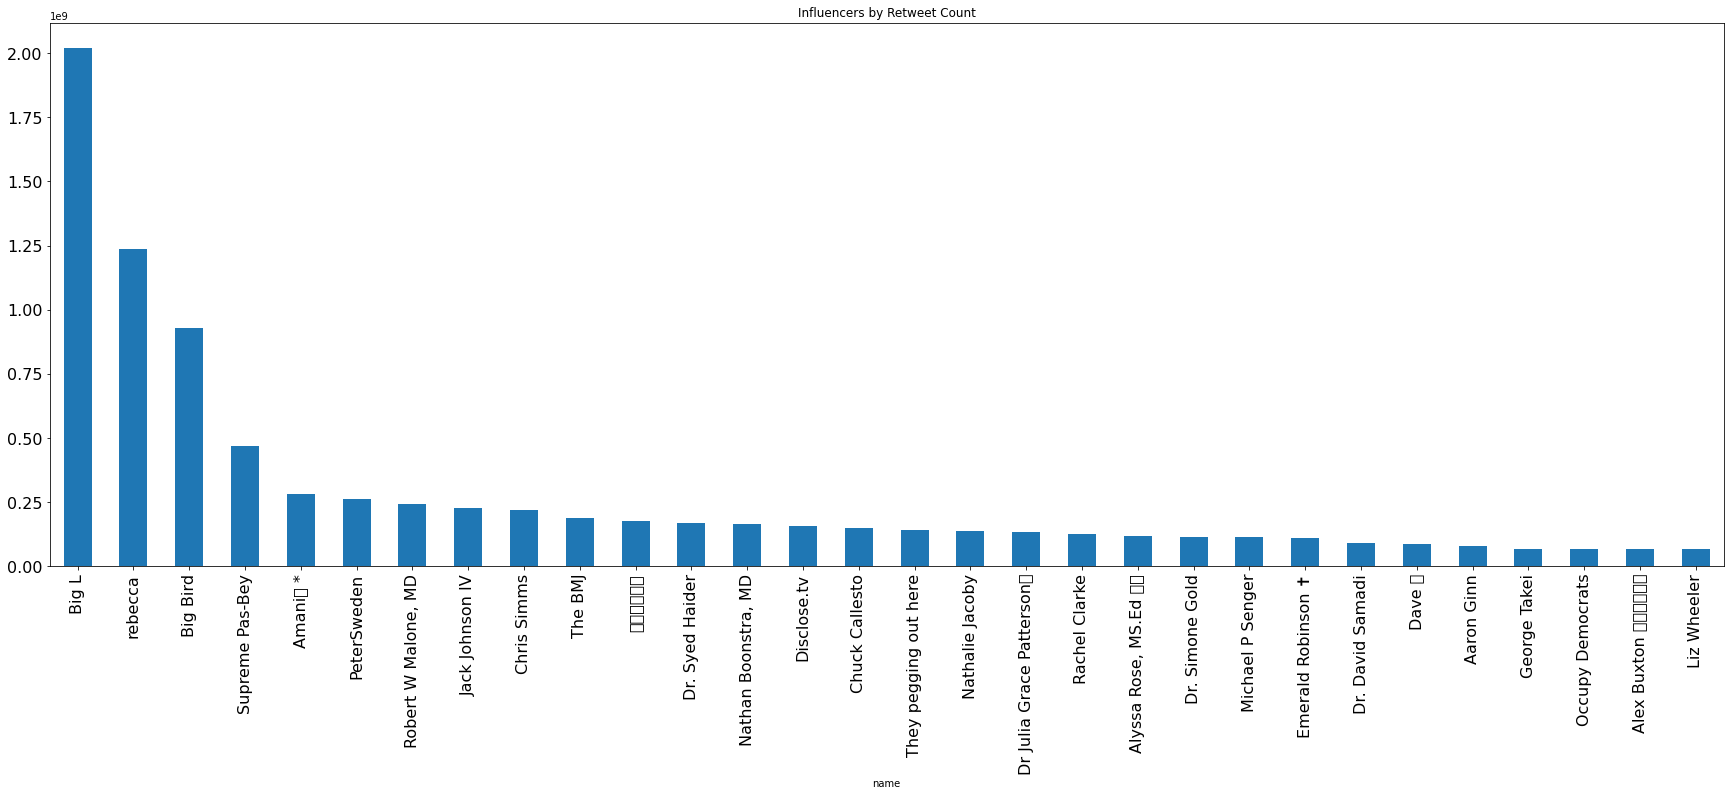

In [80]:
my_plot3 = p_retweet_ind_top30.plot(kind='bar',x='name', y='retweet_count', legend=None, title="Influencers by Retweet Count", figsize=(30,10), fontsize=16)


In [ ]:
p_retweet_ind_top30.rename

In [ ]:
p_message_vol_influencer

#### By Organization

In [30]:
df_retweet_org = df_retweet_ind.groupBy('organization').agg(sum('retweet_count').alias('retweet_count')).orderBy('retweet_count', ascending = False)



In [ ]:
df_retweet_org.show()

+------------+-------------+
|organization|retweet_count|
+------------+-------------+
|       other|  11172092175|
|        news|   1489136031|
|  government|    562060443|
|      health|    499891052|
|   celebrity|    242201381|
|social_media|     21792810|
+------------+-------------+



In [ ]:
p_df_retweet_org = df_retweet_org.limit(30).toPandas()

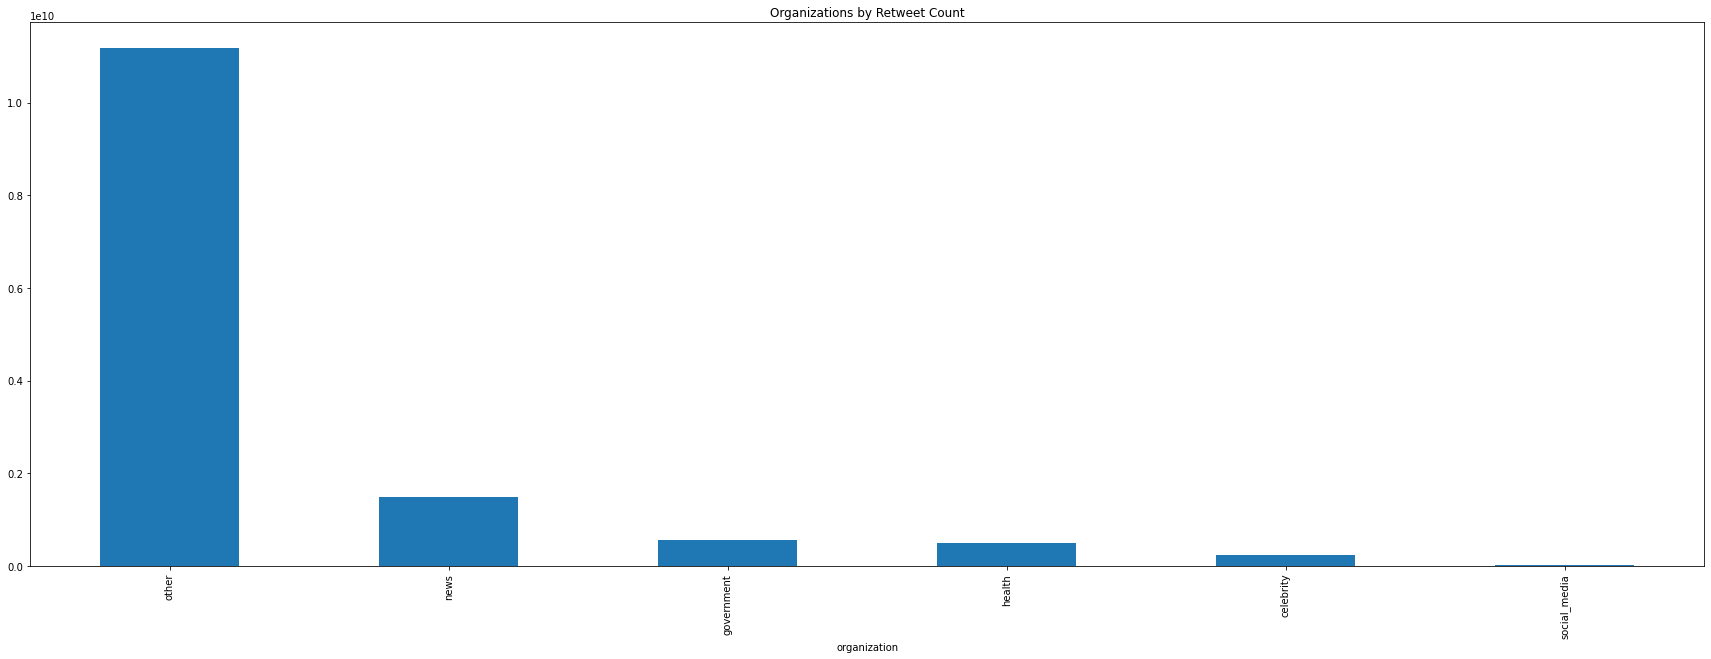

In [ ]:
my_plot4 = p_df_retweet_org.plot(kind='bar',x='organization', y='retweet_count', legend=None, title="Organizations by Retweet Count", figsize=(30,10))


In [34]:
p_df_retweet_org_exclude = p_df_retweet_org.drop(index = 0)

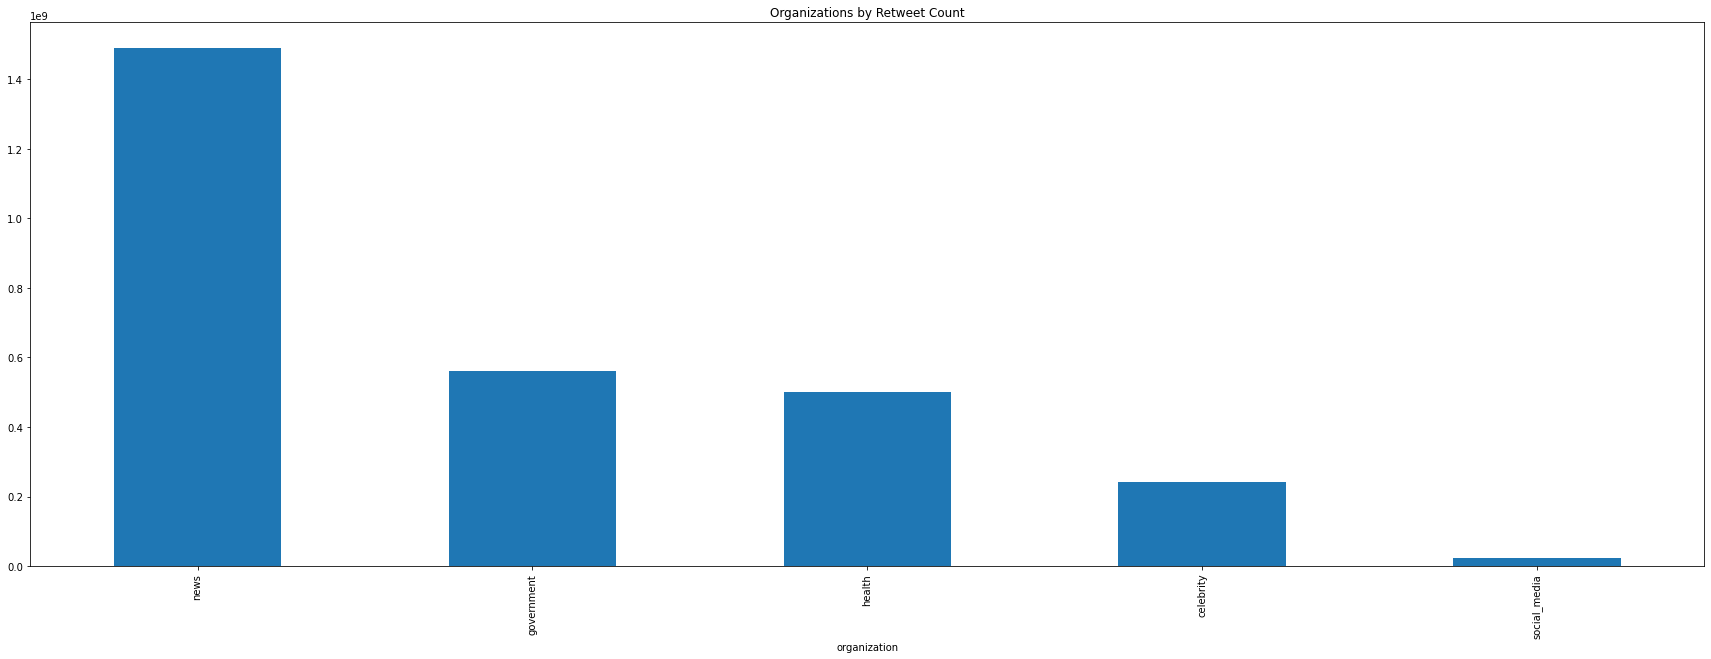

In [35]:
my_plot5 = p_df_retweet_org_exclude.plot(kind='bar',x='organization', y='retweet_count', legend=None, title="Organizations by Retweet Count", figsize=(30,10))


### Variables for Further Use

In [40]:
df_cleaned.select('user.verified').show(5)

+--------+
|verified|
+--------+
|   false|
|   false|
|   false|
|   false|
|   false|
+--------+
only showing top 5 rows



In [46]:
df_user_time = df_cleaned.select('user', 'created_at', 'text')

In [42]:
df_user_time.show(5)

+--------------------+--------------------+--------------------+
|                user|          created_at|                text|
+--------------------+--------------------+--------------------+
|[false, Mon May 2...|Sat Oct 30 02:52:...|@GarrAarghHrumph ...|
|[false, Sun Mar 2...|Sat Oct 30 02:52:...|RT @Denise_Old_La...|
|[false, Wed Nov 1...|Sat Oct 30 02:52:...|@pahpcorn @Lisa_T...|
|[false, Sat Nov 1...|Sat Oct 30 02:52:...|@polan13 @mark_do...|
|[false, Sat Feb 0...|Sat Oct 30 02:52:...|RT @LegendaryEner...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [43]:
df_user_time.printSchema()

root
 |-- user: struct (nullable = true)
 |    |-- contributors_enabled: boolean (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- default_profile: boolean (nullable = true)
 |    |-- default_profile_image: boolean (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- follow_request_sent: string (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- following: string (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- is_translator: boolean (nullable = true)
 |    |-- lang: string (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- notifications: string (nullable = true)
 |    |-- profile_background_color: str

### Converting DateTime

In [39]:
from datetime import datetime
import pytz

In [44]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [98]:
def getDate(x):
    if x is not None:
        return str(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

## UDF declaration
date_fn = udf(getDate, StringType())

## Converting datatype in spark dataframe
df = df_date.withColumn("date", to_utc_timestamp(date_fn("created_at"),"UTC")) 

In [99]:
df.select("date").show(5)

+-------------------+
|               date|
+-------------------+
|2021-10-30 02:52:21|
|2021-10-30 02:52:22|
|2021-10-30 02:52:22|
|2021-10-30 02:52:22|
|2021-10-30 02:52:22|
+-------------------+
only showing top 5 rows

